<a href="https://colab.research.google.com/github/EVA4-RS-Group/Phase2/blob/master/S6_GAN/128_1000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -q https://github.com/EVA4-RS-Group/Phase2/releases/download/S6/processed_images_step4a.zip
!unzip -q processed_images_step4a
!rm -rf processed_images_step4a.zip

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls '/content/drive/My Drive/img_a/processed_images_step4a' | wc -l

510


In [4]:
!pip install torch torchvision

In [5]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad

In [6]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [7]:
import numpy as np
import datetime
import os, sys
import glob
from tqdm import tqdm

In [8]:
from PIL import Image

In [9]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [10]:
MODEL_NAME = 'R1'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
IMAGE_DIM = ( 128, 128, 3)


In [12]:
def tensor2img(tensor):
    img = np.clip((np.transpose(tensor.detach().cpu().numpy(), [1,2,0])+1)/2.0,0,1)
    
    return img

In [13]:
def get_sample_image(G, n_noise=100, n_samples=64):
    """
        save sample 100 images
    """
    n_rows = int(np.sqrt(n_samples))
    z = (torch.rand(size=[n_samples, n_noise])*2-1).to(DEVICE) # U[-1, 1]
    x_fake = G(z)
    x_fake = torch.cat([torch.cat([x_fake[n_rows*j+i] for i in range(n_rows)], dim=1) for j in range(n_rows)], dim=2)
    result = tensor2img(x_fake)
    return result

In [14]:
class ResidualBlock(nn.Module):
    def __init__(self, inplanes, planes, kernel_size=3, stride=1, downsample=None, groups=1):
        super(ResidualBlock, self).__init__()
        p = kernel_size//2
        self.conv1 = nn.Sequential(
            nn.Conv2d(inplanes, planes, kernel_size, stride=stride, padding=p),
            nn.LeakyReLU(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(planes, planes, kernel_size, padding=p),
            nn.LeakyReLU(0.2)
        )
        self.proj = nn.Conv2d(inplanes, planes, 1) if inplanes != planes else None
    
    def forward(self, x):
        identity = x
        
        y = self.conv1(x)
        y = self.conv2(y)
        
        identity = identity if self.proj is None else self.proj(identity)
        y = y + identity
        return y

In [15]:


class Discriminator(nn.Module):
    """
        Convolutional Discriminator
    """
    def __init__(self, in_channel=1):
        super(Discriminator, self).__init__()
        self.D = nn.Sequential(
            nn.Conv2d(in_channel, 32, 3, padding=1), # (N, 32, 128, 128)
            ResidualBlock(32, 64),
            nn.AvgPool2d(3, 2, padding=1), # (N, 64, 64, 64)
            ResidualBlock(64, 128),
            nn.AvgPool2d(3, 2, padding=1), # (N, 128, 32, 32)
            ResidualBlock(128, 256),
            nn.AvgPool2d(3, 2, padding=1), # (N, 256, 16, 16)
            ResidualBlock(256, 512),
            nn.AvgPool2d(3, 2, padding=1), # (N, 512, 8, 8)
            ResidualBlock(512, 1024),
            nn.AvgPool2d(3, 2, padding=1) # (N, 1024, 4, 4)
        )
        self.fc = nn.Linear(1024*4*4, 1) # (N, 1)
        
    def forward(self, x):
        B = x.size(0)
        h = self.D(x)
        h = h.view(B, -1)
        y = self.fc(h)
        return y

In [16]:
class Generator(nn.Module):
    """
        Convolutional Generator
    """
    def __init__(self, out_channel=1, n_filters=128, n_noise=512):
        super(Generator, self).__init__()
        self.fc = nn.Linear(n_noise, 1024*4*4)
        self.G = nn.Sequential(
            ResidualBlock(1024, 512),
            nn.Upsample(scale_factor=2, mode='bilinear'), # (N, 512, 8, 8)
            ResidualBlock(512, 256),
            nn.Upsample(scale_factor=2, mode='bilinear'), # (N, 256, 16, 16)
            ResidualBlock(256, 128),
            nn.Upsample(scale_factor=2, mode='bilinear'), # (N, 128, 32, 32)
            ResidualBlock(128, 64),
            nn.Upsample(scale_factor=2, mode='bilinear'), # (N, 64, 64, 64)
            ResidualBlock(64, 32),
            nn.Upsample(scale_factor=2, mode='bilinear'), # (N, 32, 128, 128)
            ResidualBlock(32, 32),
            nn.Conv2d(32, out_channel, 3, padding=1) # (N, 3, 128, 128)
        )
        
    def forward(self, z):
        B = z.size(0)
        h = self.fc(z)
        h = h.view(B, 1024, 4, 4)
        x = self.G(h)
        return x

In [17]:
transform = transforms.Compose([transforms.Resize((IMAGE_DIM[0],IMAGE_DIM[1])),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                std=(0.5, 0.5, 0.5))
                               ]
)

In [18]:
dataset = datasets.ImageFolder('/content/drive/My Drive/img_a', transform=transform)


In [19]:
batch_size = 64
n_noise = 256

In [20]:
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)

In [21]:
D = Discriminator(in_channel=IMAGE_DIM[-1]).to(DEVICE)
G = Generator(out_channel=IMAGE_DIM[-1], n_noise=n_noise).to(DEVICE)

In [22]:
D_opt = torch.optim.RMSprop(D.parameters(), lr=1e-4, alpha=0.99)
G_opt = torch.optim.RMSprop(G.parameters(), lr=1e-4, alpha=0.99)

In [23]:
# D_scheduler = torch.optim.lr_scheduler.MultiStepLR(D_opt, milestones=[3, 10, 17], gamma=0.6)
# G_scheduler = torch.optim.lr_scheduler.MultiStepLR(G_opt, milestones=[3, 10, 17], gamma=0.6)

In [24]:
# criterion = nn.L1Loss()
def r1loss(inputs, label=None):
    # non-saturating loss with R1 regularization
    l = -1 if label else 1
    return F.softplus(l*inputs).mean()

In [25]:
max_epoch = 1000
step = 0

In [26]:
log_term = 1000
save_term = 1000

In [27]:
r1_gamma = 10

In [28]:
steps_per_epoch = len(data_loader.dataset) // batch_size
steps_per_epoch

7

In [29]:
if not os.path.exists('samples'):
    os.makedirs('samples')
    
if not os.path.exists('ckpt'):
    os.makedirs('ckpt')

In [30]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [31]:
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(tqdm(data_loader, total=len(data_loader))):
        G.zero_grad()
        # Training Discriminator
        x = images.to(DEVICE)
        x.requires_grad = True
        x_outputs = D(x)
        d_real_loss = r1loss(x_outputs, True)
        # Reference >> https://github.com/rosinality/style-based-gan-pytorch/blob/a3d000e707b70d1a5fc277912dc9d7432d6e6069/train.py
        # little different with original DiracGAN
        grad_real = grad(outputs=x_outputs.sum(), inputs=x, create_graph=True)[0]
        grad_penalty = (grad_real.view(grad_real.size(0), -1).norm(2, dim=1) ** 2).mean()
        grad_penalty = 0.5*r1_gamma*grad_penalty
        D_x_loss = d_real_loss + grad_penalty

        z = (torch.rand(size=[batch_size, n_noise])*2-1).to(DEVICE)
        x_fake = G(z)
        z_outputs = D(x_fake.detach())
        D_z_loss = r1loss(z_outputs, False)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        # Training Generator
        z = (torch.rand(size=[batch_size, n_noise])*2-1).to(DEVICE)
        x_fake = G(z)
        z_outputs = D(x_fake)
        G_loss = r1loss(z_outputs, True)
        
        G.zero_grad()
        G_loss.backward()
        G_opt.step()
        
        if step % save_term == 0:
            save_checkpoint({'global_step': step,
                 'D':D.state_dict(),
                 'G':G.state_dict(),
                 'd_optim': D_opt.state_dict(),
                 'g_optim' : G_opt.state_dict()},
                'ckpt/r1gan{:06d}.pth.tar'.format(step))
        
        if step % log_term == 0:
            dt = datetime.datetime.now().strftime('%H:%M:%S')
            print('Epoch: {}/{}, Step: {}, D Loss: {:.4f}, G Loss: {:.4f}, gp: {:.4f}, Time:{}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item(), grad_penalty.item(), dt))
            G.eval()
            img = get_sample_image(G, n_noise, n_samples=25)
            imsave('samples/{}_step{:06d}.jpg'.format(MODEL_NAME, step), img)
            G.train()
        
        step += 1
#     D_scheduler.step()
#     G_scheduler.step()

  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
 14%|█▍        | 1/7 [00:23<02:18, 23.02s/it]

Epoch: 0/1000, Step: 0, D Loss: 1.3771, G Loss: 0.2446, gp: 0.0000, Time:04:52:48


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 142/1000, Step: 1000, D Loss: 1.3667, G Loss: 1.4332, gp: 0.1209, Time:05:30:16


 86%|████████▌ | 6/7 [00:14<00:02,  2.66s/it]

Epoch: 285/1000, Step: 2000, D Loss: 0.5340, G Loss: 2.3221, gp: 0.1979, Time:06:07:39


 71%|███████▏  | 5/7 [00:12<00:05,  2.67s/it]

Epoch: 428/1000, Step: 3000, D Loss: 1.1816, G Loss: 2.0367, gp: 0.0717, Time:06:45:03


 57%|█████▋    | 4/7 [00:10<00:08,  2.67s/it]

Epoch: 571/1000, Step: 4000, D Loss: 0.7034, G Loss: 1.4136, gp: 0.2570, Time:07:22:29


 43%|████▎     | 3/7 [00:08<00:10,  2.69s/it]

Epoch: 714/1000, Step: 5000, D Loss: 0.6892, G Loss: 2.6670, gp: 0.1569, Time:07:59:56


 29%|██▊       | 2/7 [00:05<00:13,  2.67s/it]

Epoch: 857/1000, Step: 6000, D Loss: 0.9204, G Loss: 2.5666, gp: 0.1304, Time:08:37:26


100%|██████████| 7/7 [00:15<00:00,  2.26s/it]


In [32]:
save_checkpoint({'global_step': step,
     'D':D.state_dict(),
     'G':G.state_dict(),
     'd_optim': D_opt.state_dict(),
     'g_optim' : G_opt.state_dict()},
    'ckpt/r1gan{:06d}.pth.tar'.format(step))

In [33]:

G_path = sorted(glob.glob(os.path.join('ckpt', '*.pth.tar')))[-1]
state = torch.load(G_path)
G.load_state_dict(state['G'])

<All keys matched successfully>

In [34]:
G.eval()
None

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


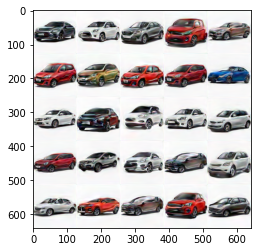

In [35]:
img = get_sample_image(G, n_noise, n_samples=25)
imshow(img)

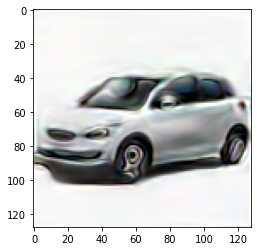

In [53]:
# Fake Image
idx = [2, 4]
row, col = IMAGE_DIM[0]*idx[0], IMAGE_DIM[1]*idx[1]
imshow(img[row:row+IMAGE_DIM[0], col:col+IMAGE_DIM[1], :])

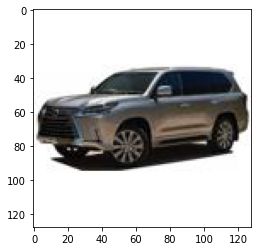

In [37]:
# Real Image
i = 14
rimg = tensor2img(images[i])
imshow(rimg)